<a href="https://colab.research.google.com/github/LucaBrocco/LCP_B_assignments/blob/Samu-Branch/group2508_Exercise3_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data and labels
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import linalg as la
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
from tqdm import tqdm
from numba import jit
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

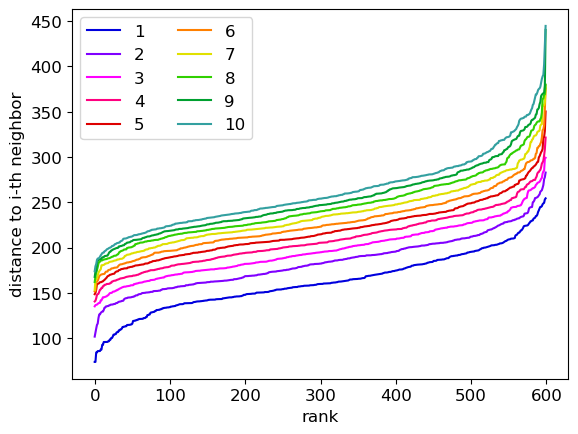

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T     ### distanza dell'i-esimo vicino per tutti i punti
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)


## t-SNE visualization, for true labels

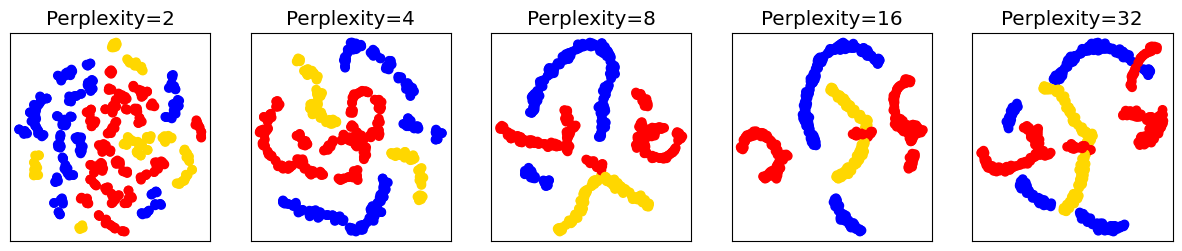

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

plt.show()

## Different random initial states (random_state=i)

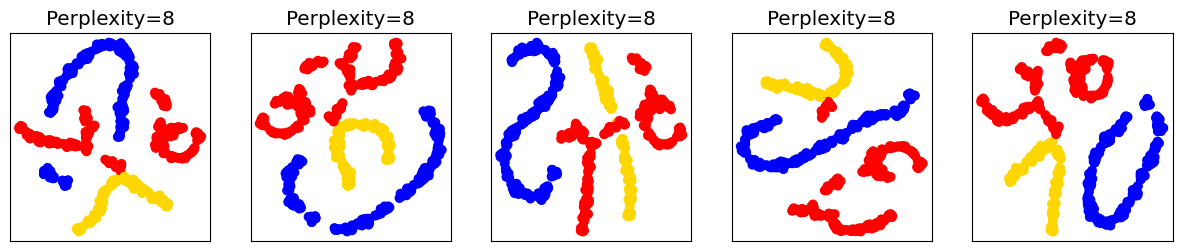

In [5]:
n_samples = N
n_components = 2
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i)
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components,
                         init='random',random_state=i,
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

plt.show()

## DBSCAN: find labels by applying clustering

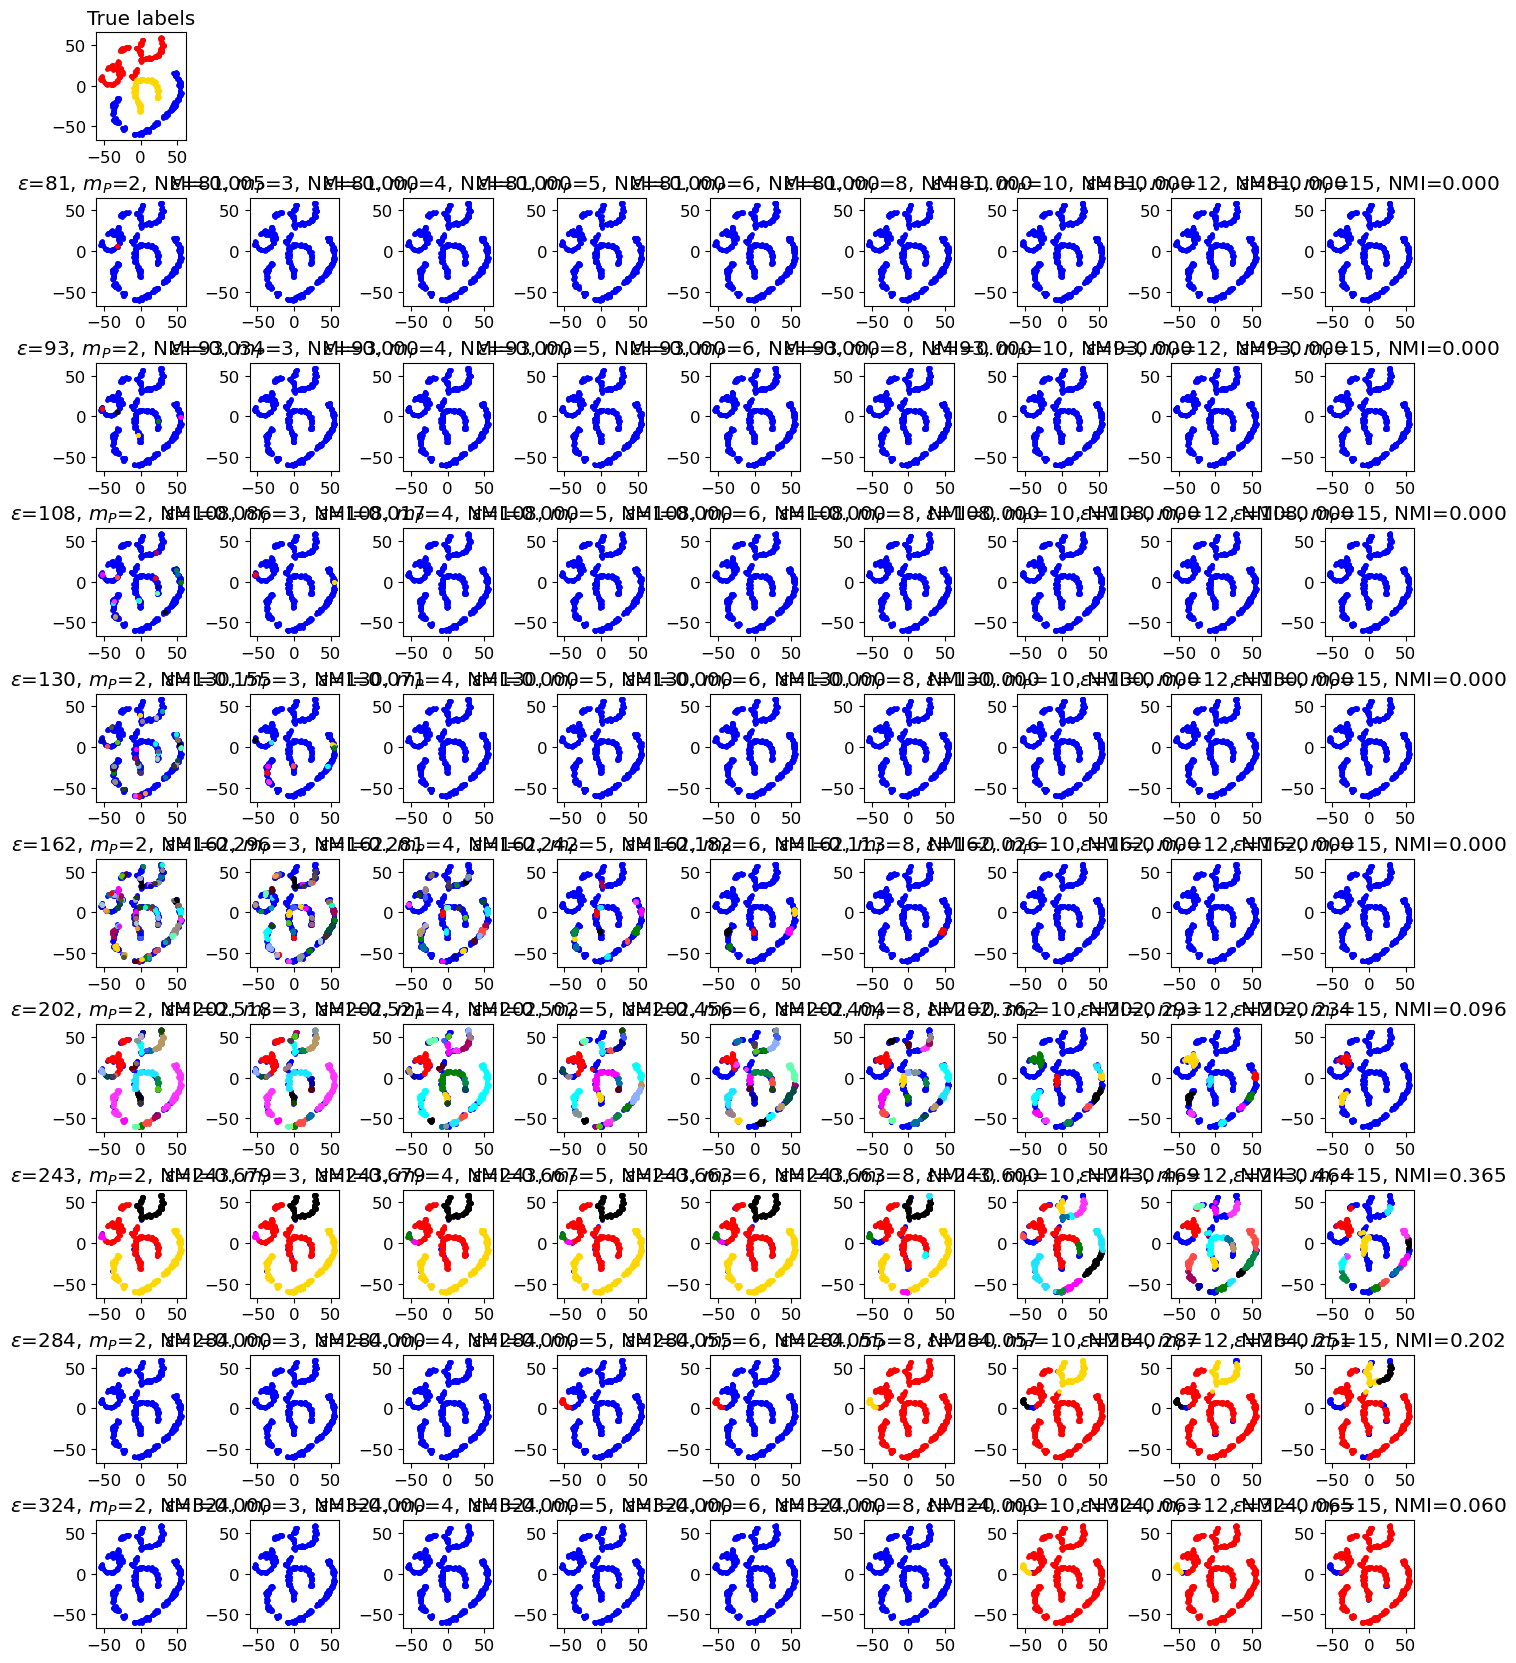

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample
                )
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r/1.75,r/1.5,r/1.25,r,1.25*r,1.5*r,1.75*r,2*r]

min_sample_range = [2,3,4,5,6,8,10,12,15]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))


plt.tight_layout(h_pad=0.5)
plt.show()


In [7]:
ms = 6


def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

#def plotting_ax(X, y, ax):
#    # plotting function
#    for i, yu in enumerate(np.unique(y)):
#        pos = (y == yu)
#        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)

min_sample_range = [i for i in range(2,50)]
eps_range = [i for i in range(1,3*r)]

nmi_matrix = np.zeros((len(eps_range), len(min_sample_range)))
for i, eps in enumerate(tqdm(eps_range, desc="Processing eps values")):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        nmi_matrix[i, j] = NMI(y_true, y_hat)




rocessing eps values: 100%|█████████████████████████████████████████████████████████| 485/485 [05:12<00:00,  1.55it/s]

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\sofia\AppData\Local\Temp\ipykernel_11452\147518837.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$\epsilon$')


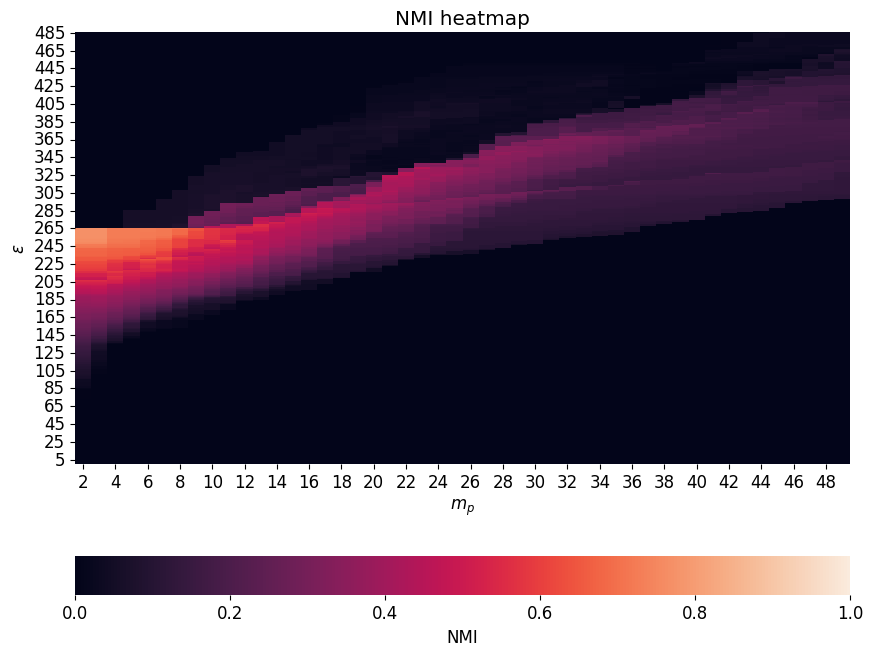

In [10]:
df = pd.DataFrame(nmi_matrix, index=eps_range, columns=min_sample_range)
df=df[::-1]
plt.figure(figsize=(10, 8))
sns.heatmap(df,cbar_kws={"label": "NMI","orientation": "horizontal"}, vmax=1)
plt.xlabel('$m_{p}$')
plt.ylabel('$\epsilon$')
plt.title("NMI heatmap")


plt.show()

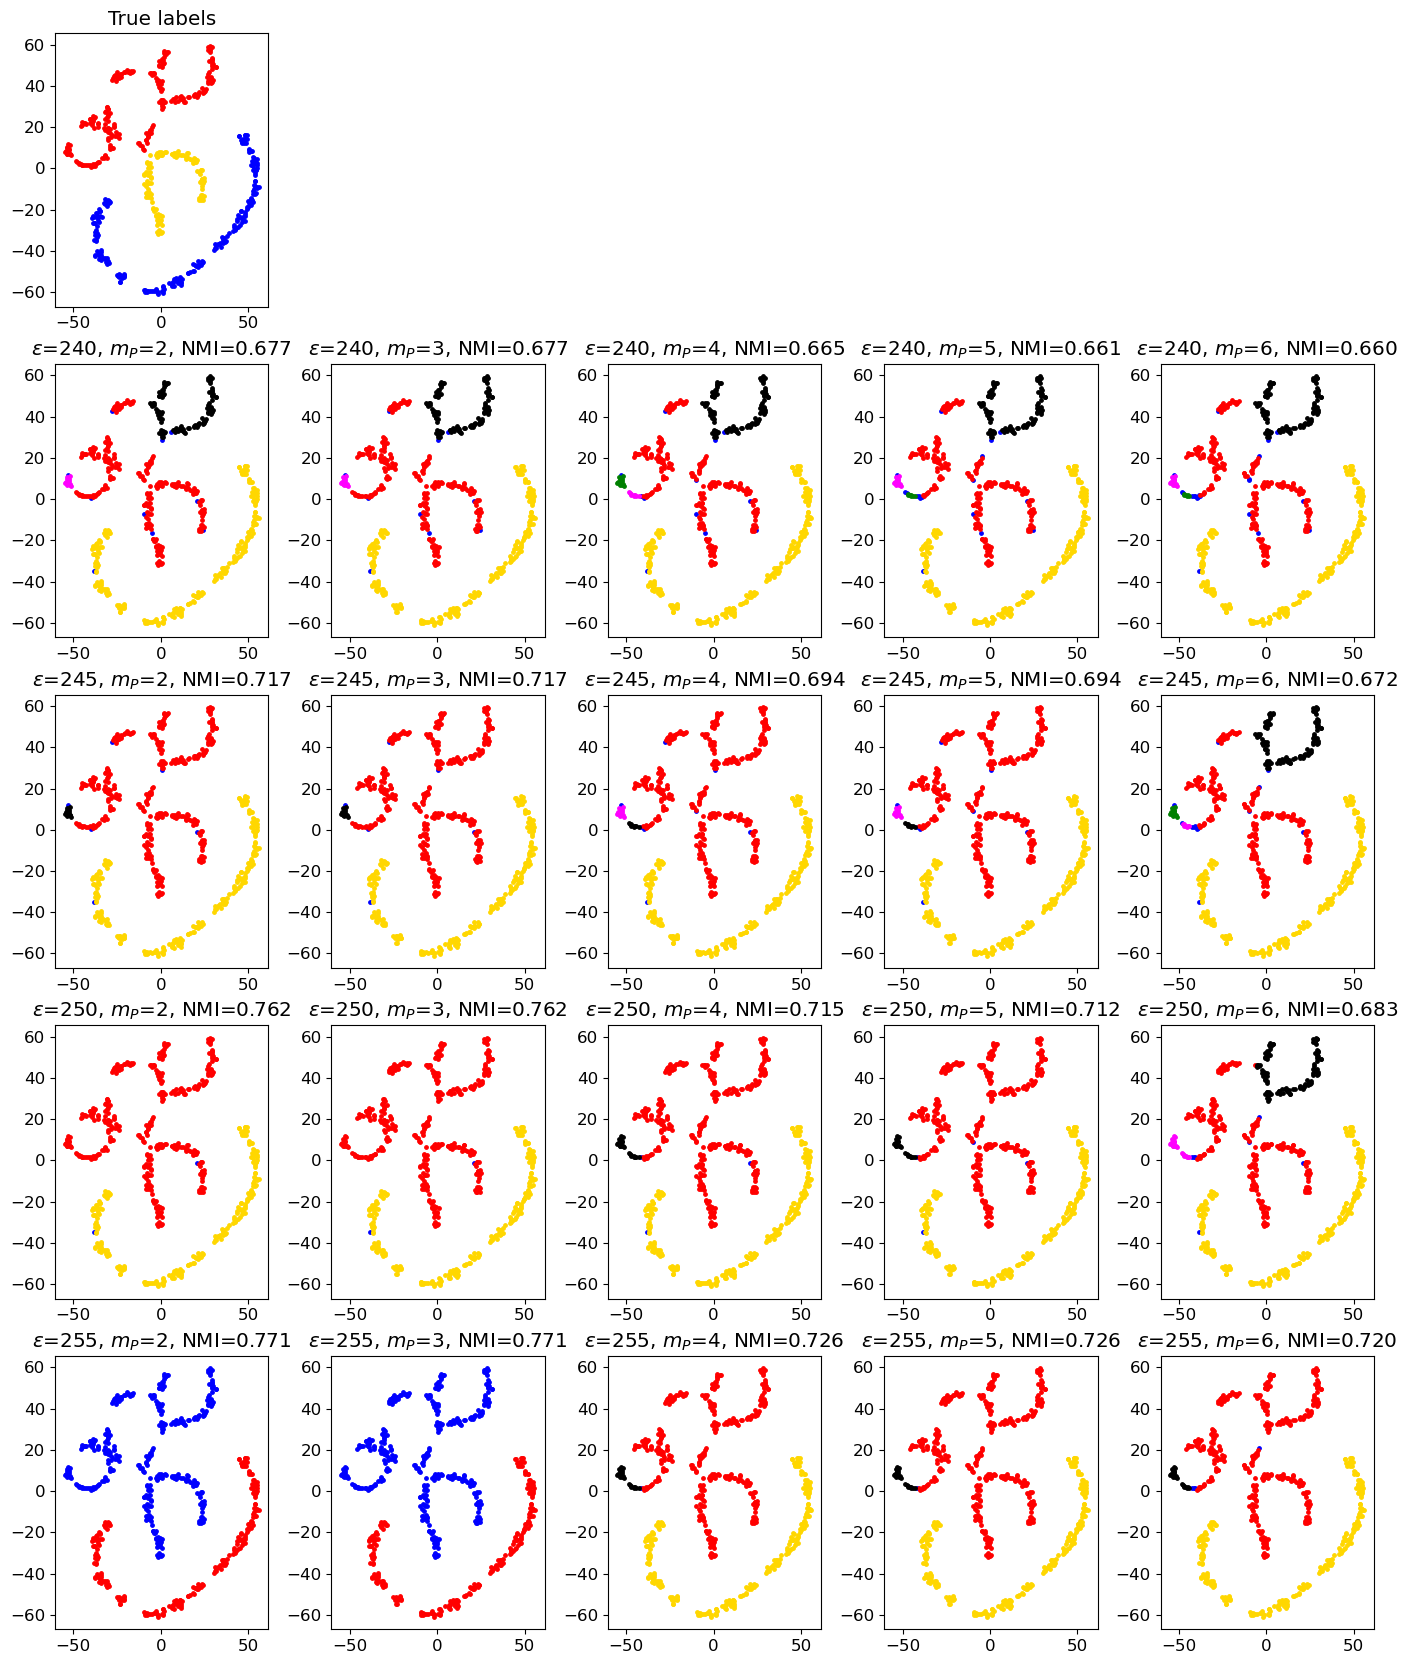

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [240,245,250,255]

min_sample_range = [2,3,4,5,6]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))


plt.tight_layout(h_pad=0.5)
plt.show()


# PCA

In [7]:
data = pd.DataFrame(data)
data

,0,1,2,3,4,5,6,7,8,9,10,11
0,61.277600,131.119710,-101.382861,-228.253328,-134.171676,-60.449339,-263.553677,-13.149802,33.433244,-133.129816,30.998251,-63.169799
1,244.628311,-343.340062,171.123629,-267.320223,-547.166904,-77.414621,97.106537,-167.418695,-42.232236,-129.516529,139.875583,-128.067112
2,190.934106,-370.408175,235.540343,276.936738,-203.158357,-27.550608,409.488204,-284.794899,-253.101438,120.666106,-105.024415,71.469216
3,165.495156,85.929731,-98.366223,-403.350400,-408.834256,-100.546551,-174.119246,36.161039,-22.596513,-304.363865,293.591522,-256.033329
4,274.166847,-232.946490,247.423794,-80.374278,-527.199608,-76.662263,114.891899,-301.953641,-43.605901,-42.773108,282.895245,-152.795593
...,...,...,...,...,...,...,...,...,...,...,...,...
595,83.352437,194.773347,-225.898050,-410.528588,-208.826122,-219.799857,-260.318071,134.562291,0.359289,-375.401082,157.164378,-276.167587
596,96.508215,114.400002,-36.962990,-252.623973,-161.186538,-74.336483,-184.438566,-84.525498,32.900011,-63.800049,24.500682,-193.600862
597,-58.748116,-176.364093,77.608917,219.736676,160.109475,65.135739,71.802746,-14.892715,53.534083,112.157621,-167.110898,108.096725
598,-145.262167,451.913594,-211.131508,-142.383468,272.806428,-43.518650,-301.290284,349.779924,6.748978,-311.544163,-68.258548,15.120295


In [8]:
# re-scale the data-set to mean zero and unitary std before executing the PCA   
for column in data.columns: 
    mean = data[column].mean()
    std = data[column].std()
    data[column] = (data[column]-mean)/std
data

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.405317,0.544828,-0.737675,-0.896400,-0.532997,-0.442362,-1.199811,-0.107374,0.526881,-0.444172,0.399881,-0.524979
1,1.534945,-1.298927,0.858421,-1.018036,-1.818865,-0.605084,0.120428,-0.938985,0.003521,-0.431592,1.026174,-0.884977
2,1.204134,-1.404114,1.235716,0.676517,-0.747788,-0.126813,1.263939,-1.571720,-1.455008,0.439413,-0.382559,0.221891
3,1.047404,0.369220,-0.720006,-1.441568,-1.388164,-0.826955,-0.872426,0.158444,0.139337,-1.040320,1.910391,-1.594832
4,1.716932,-0.869936,1.305318,-0.435977,-1.756696,-0.597868,0.185534,-1.664217,-0.005980,-0.129597,1.848863,-1.022151
...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.541321,0.792187,-1.466972,-1.463917,-0.765435,-1.970774,-1.187967,0.688891,0.298116,-1.287634,1.125624,-1.706520
596,0.622374,0.479855,-0.360362,-0.972279,-0.617108,-0.575560,-0.910201,-0.492136,0.523192,-0.202802,0.362506,-1.248506
597,-0.334163,-0.650057,0.310697,0.498424,0.383252,0.762189,0.027801,-0.116769,0.665913,0.409791,-0.739698,0.425071
598,-0.867178,1.791437,-1.380483,-0.629043,0.734136,-0.279971,-1.337951,1.849056,0.342312,-1.065318,-0.171071,-0.090688


In [9]:
cov = data.cov()
eig_val, eig_vec = la.eig(cov)
eig_val = eig_val.real
eig_vec = eig_vec.real
print(cov, '\n')
print(f"The eigenvalues are: {eig_val}", '\n')
print(f"The eigenvectors are: {eig_vec}", '\n')

          0         1         2         3         4         5         6   \
0   1.000000 -0.407756  0.134699 -0.458003 -0.920535 -0.622391 -0.060573   
1  -0.407756  1.000000 -0.865142 -0.481039  0.380882 -0.071373 -0.706880   
2   0.134699 -0.865142  1.000000  0.734111 -0.052452  0.139106  0.881919   
3  -0.458003 -0.481039  0.734111  1.000000  0.573902  0.455960  0.868099   
4  -0.920535  0.380882 -0.052452  0.573902  1.000000  0.546129  0.202754   
5  -0.622391 -0.071373  0.139106  0.455960  0.546129  1.000000  0.136329   
6  -0.060573 -0.706880  0.881919  0.868099  0.202754  0.136329  1.000000   
7  -0.587714  0.896550 -0.713791 -0.222694  0.594582  0.063123 -0.494834   
8  -0.272614 -0.027195 -0.116648 -0.050135  0.096461  0.641632 -0.302923   
9  -0.395268 -0.583404  0.672414  0.807326  0.392579  0.708886  0.638463   
10  0.664456 -0.009229 -0.343359 -0.799593 -0.806871 -0.344696 -0.606971   
11 -0.526147 -0.375856  0.643777  0.940345  0.637367  0.447159  0.805085   

          7

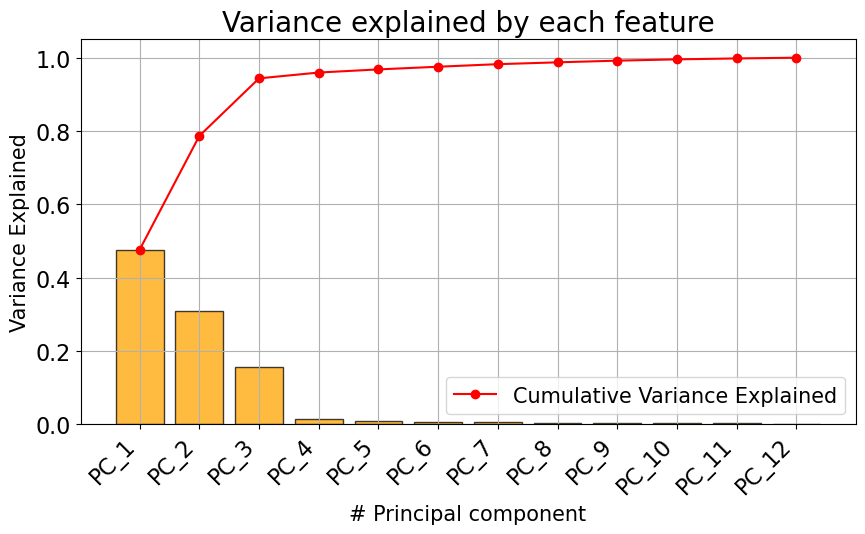

In [10]:
idx_sort = np.argsort(eig_val)[::-1]
eig_val_sort = eig_val[idx_sort]
eig_vec_sort = eig_vec[idx_sort]

var_exp = eig_val_sort / np.sum(eig_val_sort)
cum_var = np.cumsum(var_exp)

features = data.columns.tolist()
pca_list = []
for i in range(len(features)):
    pca_list.append(f"PC_{i+1}")

top_features = []
for i in range(len(features)):
    top_idx = idx_sort[i]
    top_features.append(features[top_idx])

fig = plt.figure(figsize=(10, 5))

plt.bar(pca_list, var_exp, color='Orange', edgecolor='black',alpha=0.75)
plt.plot(pca_list, cum_var, label='Cumulative Variance Explained', marker='o', color='red')
plt.ylabel('Variance Explained',fontsize=15)
plt.xlabel('# Principal component',fontsize=15)

plt.title('Variance explained by each feature',fontsize=20)
plt.legend(loc='best',fontsize=15)

plt.xticks(rotation=45, ha='right', fontsize=45)  
plt.tick_params(axis='y', labelsize=16)  
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.grid()
plt.show()
print("\n")

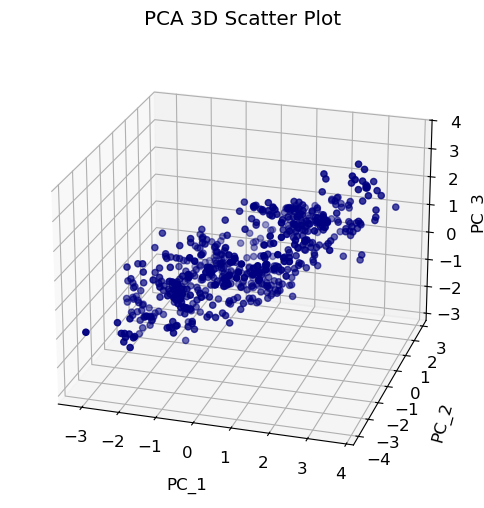

In [66]:
top_k_vec = eig_vec_sort[:, :12]

new_data = np.dot(data, top_k_vec)

fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(new_data[:, 0], new_data[:, 1], new_data[:, 2], color = "navy")
ax.set_xlabel('PC_1', labelpad = 10)
ax.set_ylabel('PC_2', labelpad = 10,rotation=75)
ax.set_zlabel('PC_3', rotation=90)

ax.set_title('PCA 3D Scatter Plot')
ax.view_init(elev=23., azim=-73, roll=0)
plt.show()

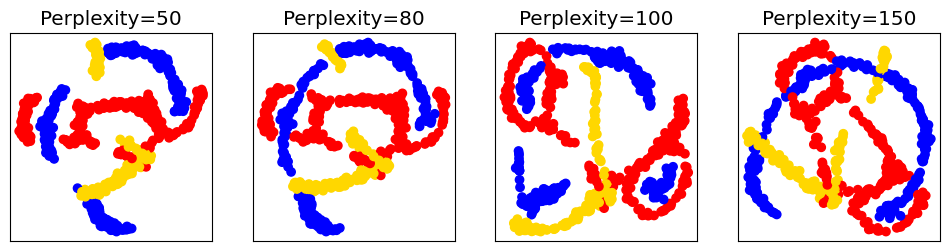

In [46]:
np.random.seed(0)
n_samples = N
n_components = 2
perplexities = [50,80,100,150]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(new_data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

plt.show()

## PART 3

In [12]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering


In [75]:
    kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X2D)
    kmeans_labels = kmeans.labels_
    


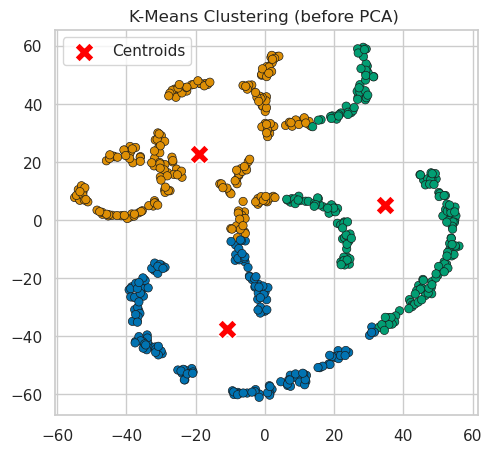

In [76]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=kmeans_labels, palette='colorblind', edgecolor='k', legend=False)
sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title("K-Means Clustering (before PCA) ")
plt.legend()


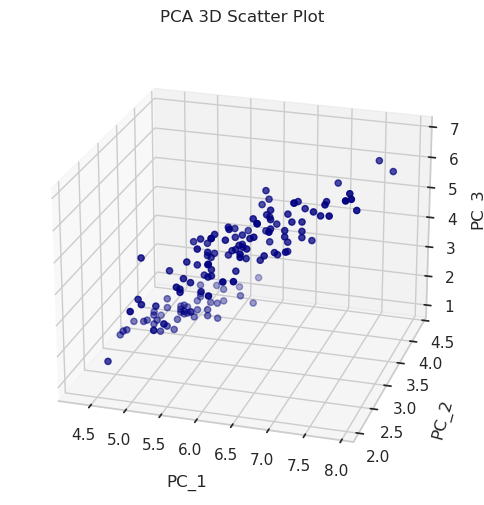

In [84]:

#fig = plt.figure(figsize=(6, 12))
#ax = fig.add_subplot(111, projection='3d')
#
#for i in range(3):
#ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = "navy")
#ax.set_xlabel('PC_1', labelpad = 10)
#ax.set_ylabel('PC_2', labelpad = 10,rotation=75)
#ax.set_zlabel('PC_3', rotation=90)
#
#ax.set_title('PCA 3D Scatter Plot')
#ax.view_init(elev=23., azim=-73, roll=0)
#plt.show()

In [77]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(Y)
kmeans_labels = kmeans.labels_

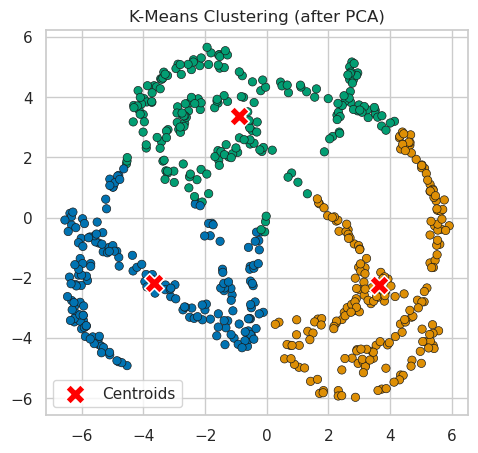

In [78]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=kmeans_labels, palette='colorblind', edgecolor='k', legend=False)
sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], color='red', marker='X', s=200, label='Centroids')
plt.title("K-Means Clustering (after PCA)")
plt.legend()


## PART 4

In [97]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#(fig, ax) = plt.subplots(2,4 , figsize=(3*5, 2.7))


model = AgglomerativeClustering()

model = model.fit(X)
ax.set_title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'